# Chapter 3 - Linear Regression

- [Load Datasets](#Load-Datasets)
- [3.1 Simple Linear Regression](#3.1-Simple-Linear-Regression)
- [3.2 Multiple Linear Regression](#3.2-Multiple-Linear-Regression)
- [3.3 Other Considerations in the Regression Model](#3.3-Other-Considerations-in-the-Regression-Model)

In [1]:
# %load ../standard_import.txt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
import seaborn as sns

from sklearn.preprocessing import scale
import sklearn.linear_model as skl_lm
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
import statsmodels.formula.api as smf

pd.set_option('display.notebook_repr_html', False)
 
%matplotlib inline
plt.style.use('seaborn-white')

D:\Program\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


### Load Datasets
Datasets available on http://www-bcf.usc.edu/~gareth/ISL/data.html

In [3]:
advertising = pd.read_csv('../data/Advertising.csv', usecols=[1,2,3,4])
advertising.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 4 columns):
TV           200 non-null float64
Radio        200 non-null float64
Newspaper    200 non-null float64
Sales        200 non-null float64
dtypes: float64(4)
memory usage: 6.3 KB


In [4]:
credit = pd.read_csv('../data/Credit.csv', usecols=list(range(1,12)))
credit['Student2'] = credit.Student.map({'No':0, 'Yes':1})
credit.head(3)

    Income  Limit  Rating  Cards  Age  Education  Gender Student Married  \
0   14.891   3606     283      2   34         11    Male      No     Yes   
1  106.025   6645     483      3   82         15  Female     Yes     Yes   
2  104.593   7075     514      4   71         11    Male      No      No   

   Ethnicity  Balance  Student2  
0  Caucasian      333         0  
1      Asian      903         1  
2      Asian      580         0  

In [5]:
auto = pd.read_csv('../data/Auto.csv', na_values='?').dropna()
auto.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 392 entries, 0 to 396
Data columns (total 9 columns):
mpg             392 non-null float64
cylinders       392 non-null int64
displacement    392 non-null float64
horsepower      392 non-null float64
weight          392 non-null int64
acceleration    392 non-null float64
year            392 non-null int64
origin          392 non-null int64
name            392 non-null object
dtypes: float64(4), int64(4), object(1)
memory usage: 30.6+ KB


## 3.1 Simple Linear Regression

### Figure 3.1 - Least squares fit

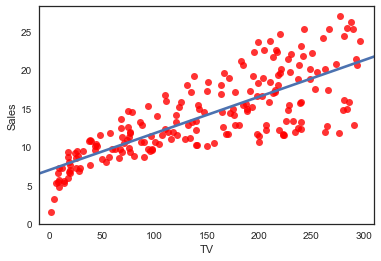

In [6]:
sns.regplot(advertising.TV, advertising.Sales, order=1, ci=None, scatter_kws={'color':'r'})
plt.xlim(-10,310)
plt.ylim(ymin=0);

### Figure 3.2 - Regression coefficients - RSS
Note that the text in the book describes the coefficients based on uncentered data, whereas the plot shows the model based on centered data. The latter is visually more appealing for explaining the concept of a minimum RSS. I think that, in order not to confuse the reader, the values on the axis of the B0 coefficients have been changed to correspond with the text. The axes on the plots below are unaltered.

In [7]:
# Regression coefficients (Ordinary Least Squares)
regr = skl_lm.LinearRegression()

X = scale(advertising.TV, with_mean=True, with_std=False).reshape(-1,1)
y = advertising.Sales

regr.fit(X,y)
print(regr.intercept_)
print(regr.coef_)

14.0225
[ 0.04753664]


In [9]:
# Create grid coordinates for plotting
B0 = np.linspace(regr.intercept_-2, regr.intercept_+2, 50)
B1 = np.linspace(regr.coef_-0.02, regr.coef_+0.02, 50)
xx, yy = np.meshgrid(B0, B1, indexing='xy')
Z = np.zeros((B0.size,B1.size))

# Calculate Z-values (RSS) based on grid of coefficients
for (i,j),v in np.ndenumerate(Z):
    Z[i,j] =((y - (xx[i,j]+X.ravel()*yy[i,j]))**2).sum()/1000

# Minimized RSS
min_RSS = r'$\beta_0$, $\beta_1$ for minimized RSS'
min_rss = np.sum((regr.intercept_+regr.coef_*X - y.values.reshape(-1,1))**2)/1000
min_rss

2.1025305831313514

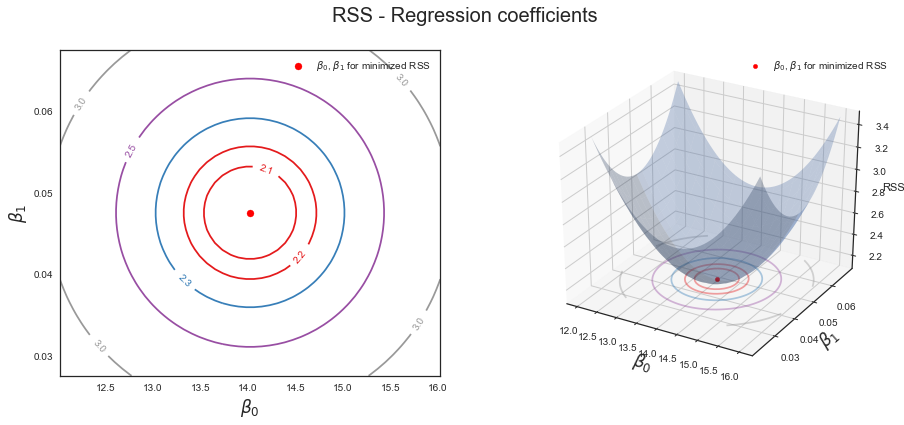

In [10]:
fig = plt.figure(figsize=(15,6))
fig.suptitle('RSS - Regression coefficients', fontsize=20)

ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122, projection='3d')

# Left plot
CS = ax1.contour(xx, yy, Z, cmap=plt.cm.Set1, levels=[2.15, 2.2, 2.3, 2.5, 3])
ax1.scatter(regr.intercept_, regr.coef_[0], c='r', label=min_RSS)
ax1.clabel(CS, inline=True, fontsize=10, fmt='%1.1f')

# Right plot
ax2.plot_surface(xx, yy, Z, rstride=3, cstride=3, alpha=0.3)
ax2.contour(xx, yy, Z, zdir='z', offset=Z.min(), cmap=plt.cm.Set1,
            alpha=0.4, levels=[2.15, 2.2, 2.3, 2.5, 3])
ax2.scatter3D(regr.intercept_, regr.coef_[0], min_rss, c='r', label=min_RSS)
ax2.set_zlabel('RSS')
ax2.set_zlim(Z.min(),Z.max())
ax2.set_ylim(0.02,0.07)

# settings common to both plots
for ax in fig.axes:
    ax.set_xlabel(r'$\beta_0$', fontsize=17)
    ax.set_ylabel(r'$\beta_1$', fontsize=17)
    ax.set_yticks([0.03,0.04,0.05,0.06])
    ax.legend()

### Confidence interval on page 67 & Table 3.1 & 3.2 - Statsmodels 

In [11]:
est = smf.ols('Sales ~ TV', advertising).fit()
est.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,7.0326,0.458,15.360,0.000,6.130,7.935
TV,0.0475,0.003,17.668,0.000,0.042,0.053


In [12]:
# RSS with regression coefficients
((advertising.Sales - (est.params[0] + est.params[1]*advertising.TV))**2).sum()/1000

2.1025305831313506

### Table 3.1 & 3.2 - Scikit-learn

In [14]:
regr = skl_lm.LinearRegression()

X = advertising.TV.values.reshape(-1,1)
y = advertising.Sales

regr.fit(X,y)
print(regr.intercept_)
print(regr.coef_)

7.03259354913
[ 0.04753664]


In [15]:
Sales_pred = regr.predict(X)
r2_score(y, Sales_pred)

0.61187505085007099

## 3.2 Multiple Linear Regression

### Table 3.3 - Statsmodels

In [16]:
est = smf.ols('Sales ~ Radio', advertising).fit()
est.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,9.3116,0.563,16.542,0.000,8.202,10.422
Radio,0.2025,0.020,9.921,0.000,0.162,0.243


In [17]:
est = smf.ols('Sales ~ Newspaper', advertising).fit()
est.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,12.3514,0.621,19.876,0.000,11.126,13.577
Newspaper,0.0547,0.017,3.300,0.001,0.022,0.087


### Table 3.4 & 3.6 - Statsmodels

In [18]:
est = smf.ols('Sales ~ TV + Radio + Newspaper', advertising).fit()
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Sales   R-squared:                       0.897
Model:                            OLS   Adj. R-squared:                  0.896
Method:                 Least Squares   F-statistic:                     570.3
Date:                Fri, 30 Jun 2017   Prob (F-statistic):           1.58e-96
Time:                        11:44:29   Log-Likelihood:                -386.18
No. Observations:                 200   AIC:                             780.4
Df Residuals:                     196   BIC:                             793.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.9389      0.312      9.422      0.000       2.324       3.554
TV             0.0458      0.001     32.809      0.000       0.043       0.049
Radio          0.1885      0.009     21.893      0.000       0.172       0.206
Newspaper     -0.0010      0.006     -0.177      0.860      -0.013       0.011
==============================================================================
Omnibus:                       60.414   Durbin-Watson:                   2.084
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              151.241
Skew:                          -1.327   Prob(JB):                     1.44e-33
Kurtosis:                       6.332   Cond. No.                         454.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Table 3.5 - Correlation Matrix

In [19]:
advertising.corr()

                 TV     Radio  Newspaper     Sales
TV         1.000000  0.054809   0.056648  0.782224
Radio      0.054809  1.000000   0.354104  0.576223
Newspaper  0.056648  0.354104   1.000000  0.228299
Sales      0.782224  0.576223   0.228299  1.000000

### Figure 3.5 - Multiple Linear Regression

In [20]:
regr = skl_lm.LinearRegression()

X = advertising[['Radio', 'TV']].as_matrix()
y = advertising.Sales

regr.fit(X,y)
print(regr.coef_)
print(regr.intercept_)

[ 0.18799423  0.04575482]
2.92109991241


In [21]:
# What are the min/max values of Radio & TV?
# Use these values to set up the grid for plotting.
advertising[['Radio', 'TV']].describe()

            Radio          TV
count  200.000000  200.000000
mean    23.264000  147.042500
std     14.846809   85.854236
min      0.000000    0.700000
25%      9.975000   74.375000
50%     22.900000  149.750000
75%     36.525000  218.825000
max     49.600000  296.400000

In [22]:
# Create a coordinate grid
Radio = np.arange(0,50)
TV = np.arange(0,300)

B1, B2 = np.meshgrid(Radio, TV, indexing='xy')
Z = np.zeros((TV.size, Radio.size))

for (i,j),v in np.ndenumerate(Z):
        Z[i,j] =(regr.intercept_ + B1[i,j]*regr.coef_[0] + B2[i,j]*regr.coef_[1])

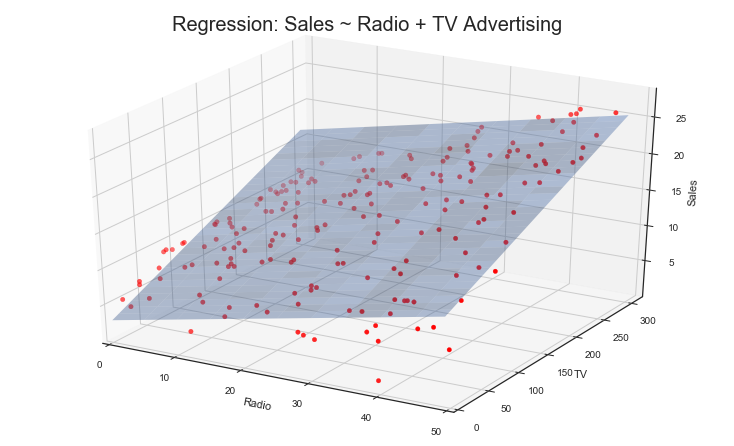

In [23]:
# Create plot
fig = plt.figure(figsize=(10,6))
fig.suptitle('Regression: Sales ~ Radio + TV Advertising', fontsize=20)

ax = axes3d.Axes3D(fig)

ax.plot_surface(B1, B2, Z, rstride=10, cstride=5, alpha=0.4)
ax.scatter3D(advertising.Radio, advertising.TV, advertising.Sales, c='r')

ax.set_xlabel('Radio')
ax.set_xlim(0,50)
ax.set_ylabel('TV')
ax.set_ylim(ymin=0)
ax.set_zlabel('Sales');

## 3.3 Other Considerations in the Regression Model

### Figure 3.6

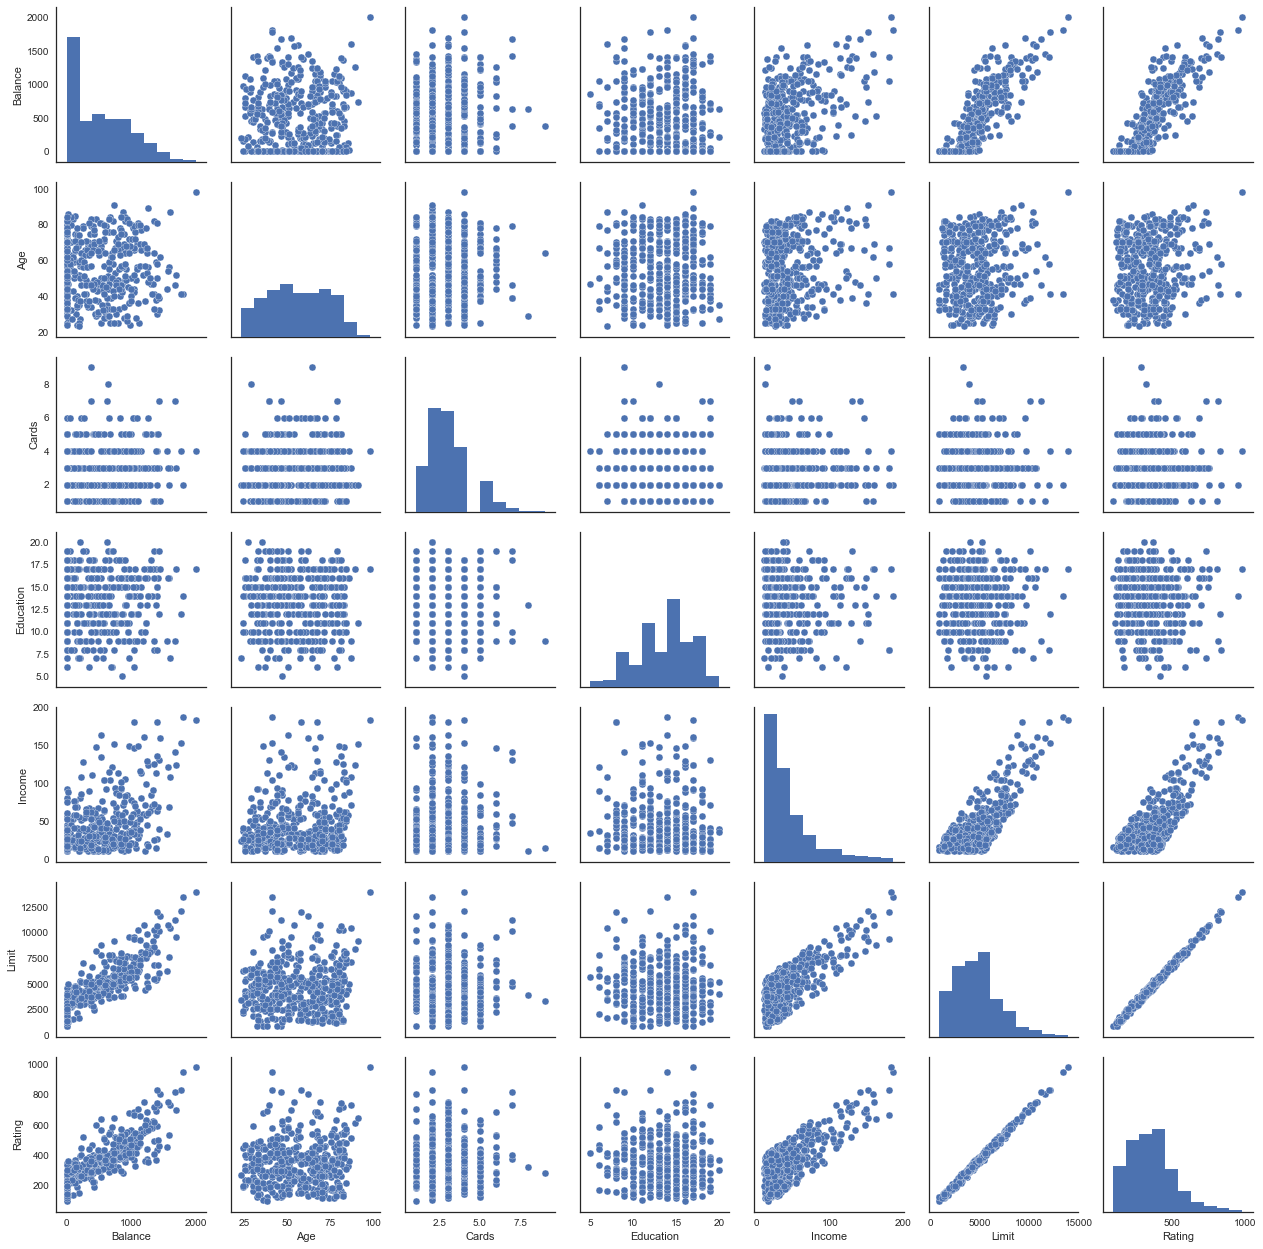

In [24]:
sns.pairplot(credit[['Balance','Age','Cards','Education','Income','Limit','Rating']]);

###  Table 3.7

In [25]:
est = smf.ols('Balance ~ Gender', credit).fit()
est.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,509.8031,33.128,15.389,0.000,444.675,574.931
Gender[T.Female],19.7331,46.051,0.429,0.669,-70.801,110.267


### Table 3.8

In [26]:
est = smf.ols('Balance ~ Ethnicity', credit).fit()
est.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,531.0000,46.319,11.464,0.000,439.939,622.061
Ethnicity[T.Asian],-18.6863,65.021,-0.287,0.774,-146.515,109.142
Ethnicity[T.Caucasian],-12.5025,56.681,-0.221,0.826,-123.935,98.930


### Table 3.9 - Interaction Variables

In [27]:
est = smf.ols('Sales ~ TV + Radio + TV*Radio', advertising).fit()
est.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,6.7502,0.248,27.233,0.000,6.261,7.239
TV,0.0191,0.002,12.699,0.000,0.016,0.022
Radio,0.0289,0.009,3.241,0.001,0.011,0.046
TV:Radio,0.0011,5.24e-05,20.727,0.000,0.001,0.001


### Figure 3.7 - Interaction between qualitative and quantative variables

In [28]:
est1 = smf.ols('Balance ~ Income + Student2', credit).fit()
regr1 = est1.params
est2 = smf.ols('Balance ~ Income + Income*Student2', credit).fit()
regr2 = est2.params

print('Regression 1 - without interaction term')
print(regr1)
print('\nRegression 2 - with interaction term')
print(regr2)

Regression 1 - without interaction term
Intercept    211.142964
Income         5.984336
Student2     382.670539
dtype: float64

Regression 2 - with interaction term
Intercept          200.623153
Income               6.218169
Student2           476.675843
Income:Student2     -1.999151
dtype: float64


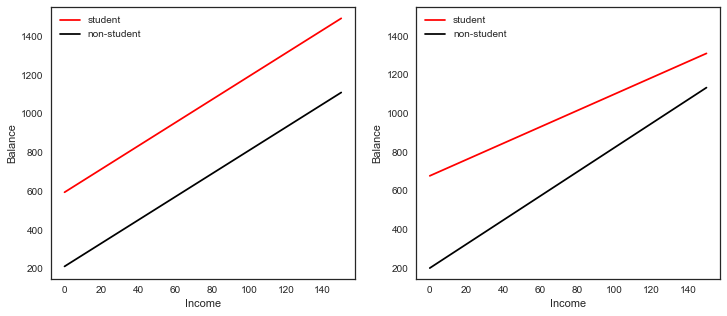

In [29]:
# Income (x-axis)
income = np.linspace(0,150)

# Balance without interaction term (y-axis)
student1 = np.linspace(regr1['Intercept']+regr1['Student2'],
                       regr1['Intercept']+regr1['Student2']+150*regr1['Income'])
non_student1 =  np.linspace(regr1['Intercept'], regr1['Intercept']+150*regr1['Income'])

# Balance with iteraction term (y-axis)
student2 = np.linspace(regr2['Intercept']+regr2['Student2'],
                       regr2['Intercept']+regr2['Student2']+
                       150*(regr2['Income']+regr2['Income:Student2']))
non_student2 =  np.linspace(regr2['Intercept'], regr2['Intercept']+150*regr2['Income'])

# Create plot
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(12,5))
ax1.plot(income, student1, 'r', income, non_student1, 'k')
ax2.plot(income, student2, 'r', income, non_student2, 'k')

for ax in fig.axes:
    ax.legend(['student', 'non-student'], loc=2)
    ax.set_xlabel('Income')
    ax.set_ylabel('Balance')
    ax.set_ylim(ymax=1550)

### Figure 3.8 - Non-linear relationships

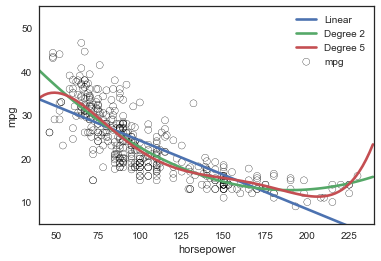

In [30]:
# With Seaborn's regplot() you can easily plot higher order polynomials.
plt.scatter(auto.horsepower, auto.mpg, facecolors='None', edgecolors='k') 
sns.regplot(auto.horsepower, auto.mpg, ci=None, label='Linear', scatter=False)
sns.regplot(auto.horsepower, auto.mpg, ci=None, label='Degree 2', order=2, scatter=False)
sns.regplot(auto.horsepower, auto.mpg, ci=None, label='Degree 5', order=5, scatter=False)
plt.legend()
plt.ylim(5,55)
plt.xlim(40,240);

### Table 3.10

In [31]:
auto['horsepower2'] = auto.horsepower**2
auto.head(3)

    mpg  cylinders  displacement  horsepower  weight  acceleration  year  \
0  18.0          8         307.0       130.0    3504          12.0    70   
1  15.0          8         350.0       165.0    3693          11.5    70   
2  18.0          8         318.0       150.0    3436          11.0    70   

   origin                       name  horsepower2  
0       1  chevrolet chevelle malibu      16900.0  
1       1          buick skylark 320      27225.0  
2       1         plymouth satellite      22500.0  

In [32]:
est = smf.ols('mpg ~ horsepower + horsepower2', auto).fit()
est.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,56.9001,1.800,31.604,0.000,53.360,60.440
horsepower,-0.4662,0.031,-14.978,0.000,-0.527,-0.405
horsepower2,0.0012,0.000,10.080,0.000,0.001,0.001


### Figure 3.9

In [34]:
regr = skl_lm.LinearRegression()

# Linear fit
X = auto.horsepower.values.reshape(-1,1)
y = auto.mpg
regr.fit(X, y)

auto['pred1'] = regr.predict(X)
auto['resid1'] = auto.mpg - auto.pred1

# Quadratic fit
X2 = auto[['horsepower', 'horsepower2']].as_matrix()
regr.fit(X2, y)

auto['pred2'] = regr.predict(X2)
auto['resid2'] = auto.mpg - auto.pred2

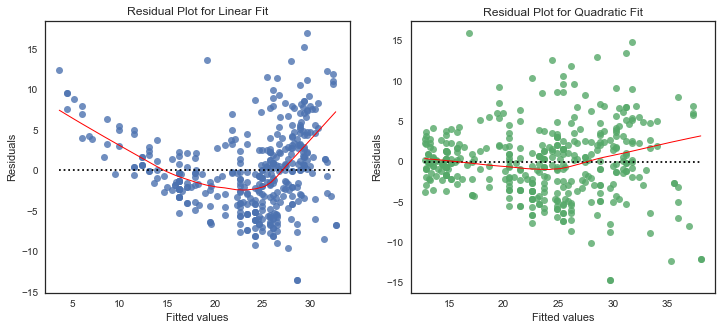

In [35]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(12,5))

# Left plot
sns.regplot(auto.pred1, auto.resid1, lowess=True, 
            ax=ax1, line_kws={'color':'r', 'lw':1})
ax1.hlines(0,xmin=ax1.xaxis.get_data_interval()[0],
           xmax=ax1.xaxis.get_data_interval()[1], linestyles='dotted')
ax1.set_title('Residual Plot for Linear Fit')

# Right plot
sns.regplot(auto.pred2, auto.resid2, lowess=True,
            line_kws={'color':'r', 'lw':1}, ax=ax2)
ax2.hlines(0,xmin=ax2.xaxis.get_data_interval()[0],
           xmax=ax2.xaxis.get_data_interval()[1], linestyles='dotted')
ax2.set_title('Residual Plot for Quadratic Fit')

for ax in fig.axes:
    ax.set_xlabel('Fitted values')
    ax.set_ylabel('Residuals')

### Figure 3.14

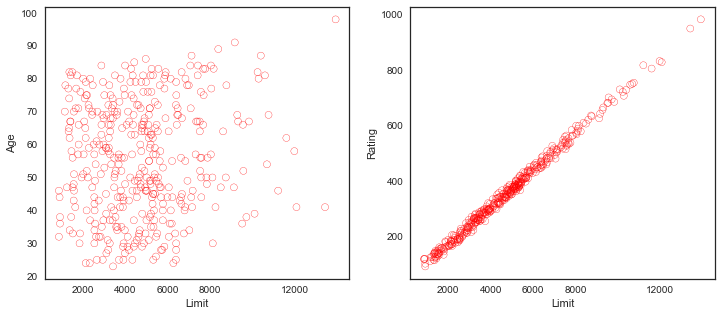

In [36]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(12,5))

# Left plot
ax1.scatter(credit.Limit, credit.Age, facecolor='None', edgecolor='r')
ax1.set_ylabel('Age')

# Right plot
ax2.scatter(credit.Limit, credit.Rating, facecolor='None', edgecolor='r')
ax2.set_ylabel('Rating')

for ax in fig.axes:
    ax.set_xlabel('Limit')
    ax.set_xticks([2000,4000,6000,8000,12000])

### Figure 3.15

In [37]:
y = credit.Balance

# Regression for left plot
X = credit[['Age', 'Limit']].as_matrix()
regr1 = skl_lm.LinearRegression()
regr1.fit(scale(X.astype('float'), with_std=False), y)
print('Age/Limit\n',regr1.intercept_)
print(regr1.coef_)

# Regression for right plot
X2 = credit[['Rating', 'Limit']].as_matrix()
regr2 = skl_lm.LinearRegression()
regr2.fit(scale(X2.astype('float'), with_std=False), y)
print('\nRating/Limit\n',regr2.intercept_)
print(regr2.coef_)

Age/Limit
 520.015
[-2.29148553  0.17336497]

Rating/Limit
 520.015
[ 2.20167217  0.02451438]


In [38]:
# Create grid coordinates for plotting
B_Age = np.linspace(regr1.coef_[0]-3, regr1.coef_[0]+3, 100)
B_Limit = np.linspace(regr1.coef_[1]-0.02, regr1.coef_[1]+0.02, 100)

B_Rating = np.linspace(regr2.coef_[0]-3, regr2.coef_[0]+3, 100)
B_Limit2 = np.linspace(regr2.coef_[1]-0.2, regr2.coef_[1]+0.2, 100)

X1, Y1 = np.meshgrid(B_Limit, B_Age, indexing='xy')
X2, Y2 = np.meshgrid(B_Limit2, B_Rating, indexing='xy')
Z1 = np.zeros((B_Age.size,B_Limit.size))
Z2 = np.zeros((B_Rating.size,B_Limit2.size))

Limit_scaled = scale(credit.Limit.astype('float'), with_std=False)
Age_scaled = scale(credit.Age.astype('float'), with_std=False)
Rating_scaled = scale(credit.Rating.astype('float'), with_std=False)

# Calculate Z-values (RSS) based on grid of coefficients
for (i,j),v in np.ndenumerate(Z1):
    Z1[i,j] =((y - (regr1.intercept_ + X1[i,j]*Limit_scaled +
                    Y1[i,j]*Age_scaled))**2).sum()/1000000
    
for (i,j),v in np.ndenumerate(Z2):
    Z2[i,j] =((y - (regr2.intercept_ + X2[i,j]*Limit_scaled +
                    Y2[i,j]*Rating_scaled))**2).sum()/1000000

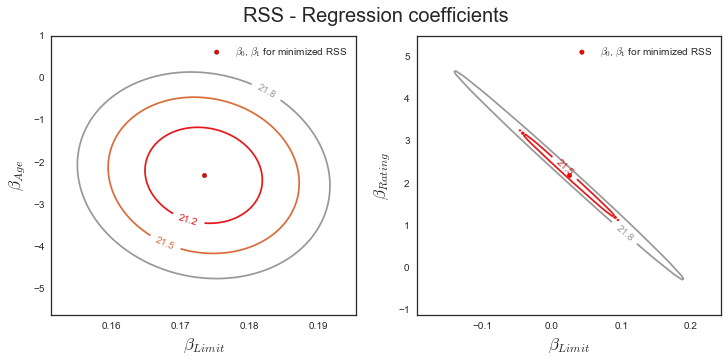

In [35]:
fig = plt.figure(figsize=(12,5))
fig.suptitle('RSS - Regression coefficients', fontsize=20)

ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

min_RSS = r'$\beta_0$, $\beta_1$ for minimized RSS'
    
# Left plot
CS = ax1.contour(X1, Y1, Z1, cmap=plt.cm.Set1, levels=[21.25, 21.5, 21.8])
ax1.scatter(regr1.coef_[1], regr1.coef_[0], c='r', label=min_RSS)
ax1.clabel(CS, inline=True, fontsize=10, fmt='%1.1f')
ax1.set_ylabel(r'$\beta_{Age}$', fontsize=17)

# Right plot
CS = ax2.contour(X2, Y2, Z2, cmap=plt.cm.Set1, levels=[21.5, 21.8])
ax2.scatter(regr2.coef_[1], regr2.coef_[0], c='r', label=min_RSS)
ax2.clabel(CS, inline=True, fontsize=10, fmt='%1.1f')
ax2.set_ylabel(r'$\beta_{Rating}$', fontsize=17)
ax2.set_xticks([-0.1, 0, 0.1, 0.2])

for ax in fig.axes:
    ax.set_xlabel(r'$\beta_{Limit}$', fontsize=17)
    ax.legend()

### Variance Inflation Factor - page 102

In [39]:
est_Age = smf.ols('Age ~ Rating + Limit', credit).fit()
est_Rating = smf.ols('Rating ~ Age + Limit', credit).fit()
est_Limit = smf.ols('Limit ~ Age + Rating', credit).fit()

print(1/(1-est_Age.rsquared))
print(1/(1-est_Rating.rsquared))
print(1/(1-est_Limit.rsquared))

1.01138468607
160.668300959
160.592879786
